<a href="https://colab.research.google.com/github/Code-Trees/Cifar10/blob/main/Cifar10_Model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
%autosave 5

Autosaving every 5 seconds


In [4]:
# !pip -q install opencv-python
# !pip -q install -U albumentations
# !pip -q  install opencv-python-headless==4.5.2.52
# !pip -q  install Pillow
# !pip -q  install rf_calc
# !pip -q install torch-lr-finder

In [5]:
def module_refresh():
    import os
    if 'strixbee' in os.listdir():
        os.system("rm -rf strixbee")
        !git clone https://github.com/Code-Trees/strixbee.git
    else:
        !git clone https://github.com/Code-Trees/strixbee.git

In [6]:
module_refresh()

Cloning into 'strixbee'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 286 (delta 183), reused 224 (delta 121), pack-reused 0
Receiving objects: 100% (286/286), 430.98 KiB | 3.29 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [7]:
try:
    #main.py
    import warnings
    warnings.filterwarnings('ignore')

    import numpy as np
    import torch
    import torch.nn.functional as F
    import torch.nn as nn

    from torch.optim import SGD
    from torch.utils.data import DataLoader
    from torch.utils.data.dataset import Dataset
    from torch.optim.lr_scheduler import StepLR

    from torchvision import transforms,datasets

    import numpy as np
    import matplotlib.pyplot as plt
    from torchsummary import summary
    import random
    import seaborn as sns
    import gc

    import albumentations as A
    from albumentations.augmentations.geometric.resize import Resize
    from albumentations.pytorch.transforms import ToTensorV2

    from rf_calc import receptive_field
    import seaborn as sns
    import matplotlib.pyplot as plt
except:
    !pip -q install opencv-python
    !pip -q install -U albumentations
    !pip -q  install opencv-python-headless==4.5.2.52
    !pip -q  install Pillow
    !pip -q  install rf_calc
    !pip -q install torch-lr-finder

    import warnings
    warnings.filterwarnings('ignore')

    import numpy as np
    import torch
    import torch.nn.functional as F
    import torch.nn as nn

    from torch.optim import SGD
    from torch.utils.data import DataLoader
    from torch.utils.data.dataset import Dataset
    from torch.optim.lr_scheduler import StepLR

    from torchvision import transforms,datasets

    import numpy as np
    import matplotlib.pyplot as plt
    from torchsummary import summary
    import random
    import seaborn as sns
    import gc

    import albumentations as A
    from albumentations.augmentations.geometric.resize import Resize
    from albumentations.pytorch.transforms import ToTensorV2

    from rf_calc import receptive_field
    import seaborn as sns
    import matplotlib.pyplot as plt

In [8]:
from strixbee.utils.data_iter import get_data,get_data_stats
from strixbee.utils.data_transforms import AlbumDataset
from strixbee.utils.optimizer_utils import *
from strixbee.utils.train_test import *
from strixbee.utils.gpu import clean_gpu
from strixbee.utils.plots import * 
from strixbee.utils import *
from strixbee.model.custom_layer import *

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified
Train Shape: (50000, 32, 32, 3) Test Shape: (10000, 32, 32, 3) 



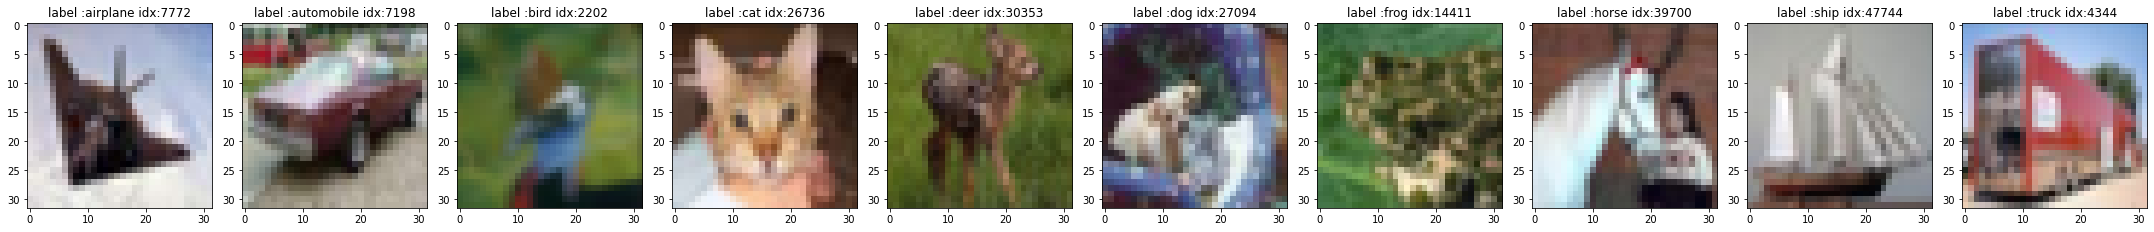

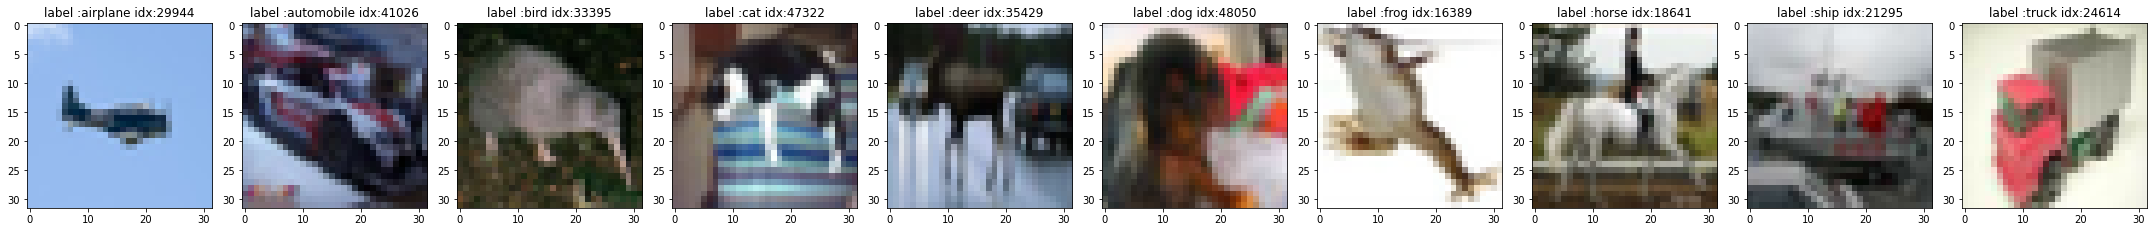

In [9]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
train,test = get_data()
print(f"Train Shape: {train.data.shape} Test Shape: {test.data.shape} \n")
plot_unique_images(train,labels =labels)
plot_unique_images(train,labels =labels)

In [10]:
mean,std  = get_data_stats(train,test,img_norm_typ ='train',plot = False)
print(f"Mean :{mean} , Std :{std}")

Mean :(0.49139967861519745, 0.4821584083946076, 0.44653091444546616) , Std :(0.2470322324632823, 0.24348512800005553, 0.2615878417279641)


<Figure size 1080x360 with 0 Axes>

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
#model1
class Cifar10Net1(nn.Module):
    def __init__(self,dropout_val = 0,norm_type = 'bn'):
        super(Cifar10Net1,self).__init__()
        self.norm_type = norm_type
        self.drop = dropout_val

        self.block1 = nn.Sequential(
            ConvBlock(in_channels=3,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop)
            )
        
        # self.pool1 =nn.MaxPool2d(kernel_size=(2,2),stride = 2)
        # self.pool1 =ConvBlock(in_channels=32,out_channels =32,kernel_size = (3,3),stride = 2,padding = 0)


        self.block2 = nn.Sequential(
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 2, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),

            # ConvBlock(in_channels=32,out_channels=64,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            )

        # self.pool2 = nn.MaxPool2d(kernel_size = (2,2),stride  = 2)
        # self.pool2 =ConvBlock(in_channels=32,out_channels =32,kernel_size = (3,3),stride = 2,padding = 0)


        self.block3 = nn.Sequential(
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 2, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            )

        # self.pool3 = nn.MaxPool2d(kernel_size = (2,2),stride  = 2)
        # self.pool3 =ConvBlock(in_channels=32,out_channels =32,kernel_size = (3,3),stride = 2,padding = 0)


        self.block4 = nn.Sequential(
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 2, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            ConvBlock(in_channels=32,out_channels=32,kernel_size = (3,3),stride = 1, padding = 1,norm_type = self.norm_type,dropout_val= self.drop),
            )
        # self.pool4 = nn.MaxPool2d(kernel_size = (2,2),stride  = 2)
        # self.pool4 =ConvBlock(in_channels=64,out_channels =64,kernel_size = (3,3),stride = 2,padding = 0)

        self.GAP = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.con1 = nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = (1,1),padding = 0,stride = 1,bias= True)
        self.con2 = nn.Conv2d(in_channels = 64,out_channels = 10,kernel_size = (1,1),bias= True)
        

    def forward(self,x):
        x = self.block1(x)
        # x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.block3(x)
        # x = self.pool3(x)
        x = self.block4(x)
        # x = self.pool4(x)
        x = self.GAP(x)
        x = self.con1(x)
        x = self.con2(x)
        x = x.view(-1,10)
        # return x
        return F.log_softmax(x,dim = -1)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_demo =Cifar10Net1(dropout_val = 0.00,norm_type = 'bn').to(device)
summary(model_demo,(3,32,32))
df = receptive_field(model_demo,32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         Dropout2d-4           [-1, 32, 32, 32]               0
         ConvBlock-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           9,216
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
         Dropout2d-9           [-1, 32, 32, 32]               0
        ConvBlock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]           9,216
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
        Dropout2d-14           [-1, 32,

In [14]:
def Run_Model(model_class,train_loader,test_loader,epochs , L1 = False):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print (f'running on {device} \n')
    #take input as normal_type ['gbn','bn','gn','ln']
    model = model_class.to(device)
    try:
        # print(summary(model,input_size = (3,32,32)))
        pass
    except:
        pass

    # optimizer,scheduler = get_optimizer(model,lr =0.01,scheduler = True,scheduler_type = 'steplr')
    # optimizer,scheduler = get_optimizer(model,lr =0.01,scheduler = True,scheduler_type = 'reducelronplateau')
    # optimizer = get_optimizer(model,lr =0.01,scheduler = False,scheduler_type = None)
    # optimizer,scheduler = get_optimizer(model,scheduler = True )
    optimizer = SGD(params = model.parameters(),lr = 0.01,momentum = 0.9)
    # scheduler = StepLR(optimizer,step_size = 20,gamma = 0.1)

    train_losses = []
    train_accuracy = []
    test_losses =[]
    test_accuracy = []

    for EPOCHS in range(0,epochs):
        if L1 == True:
            train_loss, train_acc = trainning(model,device,train_loader,optimizer,EPOCHS,L1 = L1)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)
        else:
            train_loss, train_acc = trainning(model,device,train_loader,optimizer,EPOCHS)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)

        test_loss,test_acc = testing(model,device,test_loader,optimizer,EPOCHS)

        test_accuracy.append(test_acc)
        test_losses.append(test_loss)
        
        # scheduler.step()
        # scheduler.step(train_loss)
        
        try:
            if (EPOCHS >=3)&(max(test_accuracy[:-1]) < test_accuracy[-1]) & (max(test_accuracy) >= .75):
                checkpoint = {'epoch': EPOCHS + 1,'valid_loss_min': test_losses[-1],'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),} # Export to TorchScript
                torch.save(checkpoint ,'./Model_cifar10.pt') # Save
                print (f"Achieved: {max(test_accuracy)*100}% Test Accuracy !!")
        except:
            print('Model Saving Failed !!')
        print(f"best test accuracy {max(test_accuracy)}\n")
        # print ("LR :{}\n".format(scheduler.get_lr()[0]))
    return model,train_losses, train_accuracy,test_losses,test_accuracy


Files already downloaded and verified
Files already downloaded and verified
running on cuda 



Train ==> Epochs: 0 Batch:  781 loss: 1.2355623245239258 Accuracy: 28.14% : 100%|██████████| 782/782 [00:13<00:00, 57.85it/s]
Test ==> Epochs: 0 Batch:  156 loss: 0.022636863648891448 Accuracy: 45.85% : 100%|██████████| 157/157 [00:01<00:00, 104.34it/s]


Model Saving Failed !!
best test accuracy 0.4585



Train ==> Epochs: 1 Batch:  781 loss: 1.311585783958435 Accuracy: 40.80% : 100%|██████████| 782/782 [00:13<00:00, 56.84it/s]
Test ==> Epochs: 1 Batch:  156 loss: 0.020087221145629882 Accuracy: 52.35% : 100%|██████████| 157/157 [00:01<00:00, 106.17it/s]


best test accuracy 0.5235



Train ==> Epochs: 2 Batch:  781 loss: 1.3549200296401978 Accuracy: 46.84% : 100%|██████████| 782/782 [00:13<00:00, 57.22it/s]
Test ==> Epochs: 2 Batch:  156 loss: 0.017807507693767547 Accuracy: 58.74% : 100%|██████████| 157/157 [00:01<00:00, 106.37it/s]


best test accuracy 0.5874



Train ==> Epochs: 3 Batch:  781 loss: 1.254399299621582 Accuracy: 50.63% : 100%|██████████| 782/782 [00:13<00:00, 56.92it/s]
Test ==> Epochs: 3 Batch:  156 loss: 0.01656162653565407 Accuracy: 61.68% : 100%|██████████| 157/157 [00:01<00:00, 105.42it/s]


best test accuracy 0.6168



Train ==> Epochs: 4 Batch:  781 loss: 1.7940021753311157 Accuracy: 53.29% : 100%|██████████| 782/782 [00:13<00:00, 56.65it/s]
Test ==> Epochs: 4 Batch:  156 loss: 0.01539239689707756 Accuracy: 64.91% : 100%|██████████| 157/157 [00:01<00:00, 104.19it/s]


best test accuracy 0.6491



Train ==> Epochs: 5 Batch:  781 loss: 1.7550654411315918 Accuracy: 55.39% : 100%|██████████| 782/782 [00:13<00:00, 56.90it/s]
Test ==> Epochs: 5 Batch:  156 loss: 0.015652296197414397 Accuracy: 65.00% : 100%|██████████| 157/157 [00:01<00:00, 97.39it/s] 


best test accuracy 0.65



Train ==> Epochs: 6 Batch:  781 loss: 1.1263890266418457 Accuracy: 57.31% : 100%|██████████| 782/782 [00:13<00:00, 56.42it/s]
Test ==> Epochs: 6 Batch:  156 loss: 0.013905001848936081 Accuracy: 68.75% : 100%|██████████| 157/157 [00:01<00:00, 103.30it/s]


best test accuracy 0.6875



Train ==> Epochs: 7 Batch:  781 loss: 1.058142900466919 Accuracy: 58.10% : 100%|██████████| 782/782 [00:13<00:00, 56.63it/s]
Test ==> Epochs: 7 Batch:  156 loss: 0.013808296138048171 Accuracy: 68.93% : 100%|██████████| 157/157 [00:01<00:00, 102.89it/s]


best test accuracy 0.6893



Train ==> Epochs: 8 Batch:  781 loss: 1.1976027488708496 Accuracy: 59.47% : 100%|██████████| 782/782 [00:14<00:00, 55.85it/s]
Test ==> Epochs: 8 Batch:  156 loss: 0.013080645483732223 Accuracy: 70.71% : 100%|██████████| 157/157 [00:01<00:00, 108.67it/s]


best test accuracy 0.7071



Train ==> Epochs: 9 Batch:  781 loss: 1.3985885381698608 Accuracy: 60.37% : 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]
Test ==> Epochs: 9 Batch:  156 loss: 0.012593311148881911 Accuracy: 71.92% : 100%|██████████| 157/157 [00:01<00:00, 101.25it/s]


best test accuracy 0.7192



Train ==> Epochs: 10 Batch:  781 loss: 1.1674509048461914 Accuracy: 61.01% : 100%|██████████| 782/782 [00:13<00:00, 57.86it/s]
Test ==> Epochs: 10 Batch:  156 loss: 0.012347359582781792 Accuracy: 72.38% : 100%|██████████| 157/157 [00:01<00:00, 100.22it/s]


best test accuracy 0.7238



Train ==> Epochs: 11 Batch:  781 loss: 1.2970162630081177 Accuracy: 62.01% : 100%|██████████| 782/782 [00:13<00:00, 56.47it/s]
Test ==> Epochs: 11 Batch:  156 loss: 0.012026561126112938 Accuracy: 73.18% : 100%|██████████| 157/157 [00:01<00:00, 100.70it/s]


best test accuracy 0.7318



Train ==> Epochs: 12 Batch:  781 loss: 1.411987066268921 Accuracy: 62.86% : 100%|██████████| 782/782 [00:13<00:00, 56.90it/s]
Test ==> Epochs: 12 Batch:  156 loss: 0.011891840270161628 Accuracy: 73.26% : 100%|██████████| 157/157 [00:01<00:00, 106.94it/s]


best test accuracy 0.7326



Train ==> Epochs: 13 Batch:  781 loss: 1.1131795644760132 Accuracy: 62.96% : 100%|██████████| 782/782 [00:13<00:00, 56.15it/s]
Test ==> Epochs: 13 Batch:  156 loss: 0.011915869897603988 Accuracy: 73.85% : 100%|██████████| 157/157 [00:01<00:00, 102.88it/s]


best test accuracy 0.7385



Train ==> Epochs: 14 Batch:  781 loss: 0.8508459329605103 Accuracy: 63.86% : 100%|██████████| 782/782 [00:13<00:00, 56.35it/s]
Test ==> Epochs: 14 Batch:  156 loss: 0.011349429932236671 Accuracy: 75.28% : 100%|██████████| 157/157 [00:01<00:00, 104.57it/s]


Achieved: 75.28% Test Accuracy !!
best test accuracy 0.7528



Train ==> Epochs: 15 Batch:  781 loss: 1.0689740180969238 Accuracy: 64.25% : 100%|██████████| 782/782 [00:13<00:00, 57.08it/s]
Test ==> Epochs: 15 Batch:  156 loss: 0.011400549399852753 Accuracy: 75.14% : 100%|██████████| 157/157 [00:01<00:00, 105.18it/s]


best test accuracy 0.7528



Train ==> Epochs: 16 Batch:  781 loss: 1.0241429805755615 Accuracy: 64.65% : 100%|██████████| 782/782 [00:13<00:00, 57.48it/s]
Test ==> Epochs: 16 Batch:  156 loss: 0.011314292246103287 Accuracy: 74.62% : 100%|██████████| 157/157 [00:01<00:00, 104.17it/s]


best test accuracy 0.7528



Train ==> Epochs: 17 Batch:  781 loss: 1.2945560216903687 Accuracy: 65.15% : 100%|██████████| 782/782 [00:13<00:00, 56.74it/s]
Test ==> Epochs: 17 Batch:  156 loss: 0.011068844839930534 Accuracy: 75.95% : 100%|██████████| 157/157 [00:01<00:00, 102.65it/s]


Achieved: 75.94999999999999% Test Accuracy !!
best test accuracy 0.7595



Train ==> Epochs: 18 Batch:  781 loss: 0.8211849927902222 Accuracy: 65.52% : 100%|██████████| 782/782 [00:13<00:00, 55.89it/s]
Test ==> Epochs: 18 Batch:  156 loss: 0.011318414670228958 Accuracy: 74.91% : 100%|██████████| 157/157 [00:01<00:00, 100.12it/s]


best test accuracy 0.7595



Train ==> Epochs: 19 Batch:  781 loss: 0.9110680818557739 Accuracy: 65.49% : 100%|██████████| 782/782 [00:13<00:00, 56.40it/s]
Test ==> Epochs: 19 Batch:  156 loss: 0.01075528168976307 Accuracy: 76.18% : 100%|██████████| 157/157 [00:01<00:00, 100.67it/s]


Achieved: 76.18% Test Accuracy !!
best test accuracy 0.7618



Train ==> Epochs: 20 Batch:  781 loss: 1.2324857711791992 Accuracy: 66.08% : 100%|██████████| 782/782 [00:13<00:00, 57.12it/s]
Test ==> Epochs: 20 Batch:  156 loss: 0.011143531107902527 Accuracy: 75.58% : 100%|██████████| 157/157 [00:01<00:00, 105.83it/s]


best test accuracy 0.7618



Train ==> Epochs: 21 Batch:  781 loss: 1.0228397846221924 Accuracy: 66.47% : 100%|██████████| 782/782 [00:13<00:00, 56.31it/s]
Test ==> Epochs: 21 Batch:  156 loss: 0.010644645020365716 Accuracy: 76.73% : 100%|██████████| 157/157 [00:01<00:00, 101.42it/s]


Achieved: 76.73% Test Accuracy !!
best test accuracy 0.7673



Train ==> Epochs: 22 Batch:  781 loss: 1.1370553970336914 Accuracy: 66.55% : 100%|██████████| 782/782 [00:13<00:00, 56.37it/s]
Test ==> Epochs: 22 Batch:  156 loss: 0.01059602267742157 Accuracy: 77.04% : 100%|██████████| 157/157 [00:01<00:00, 104.99it/s]


Achieved: 77.03999999999999% Test Accuracy !!
best test accuracy 0.7704



Train ==> Epochs: 23 Batch:  781 loss: 0.7034897208213806 Accuracy: 66.71% : 100%|██████████| 782/782 [00:13<00:00, 56.58it/s]
Test ==> Epochs: 23 Batch:  156 loss: 0.010402818763256072 Accuracy: 77.09% : 100%|██████████| 157/157 [00:01<00:00, 105.79it/s]


Achieved: 77.09% Test Accuracy !!
best test accuracy 0.7709



Train ==> Epochs: 24 Batch:  781 loss: 1.0859713554382324 Accuracy: 66.94% : 100%|██████████| 782/782 [00:13<00:00, 56.64it/s]
Test ==> Epochs: 24 Batch:  156 loss: 0.010365402236580848 Accuracy: 77.56% : 100%|██████████| 157/157 [00:01<00:00, 101.68it/s]


Achieved: 77.56% Test Accuracy !!
best test accuracy 0.7756



Train ==> Epochs: 25 Batch:  781 loss: 0.5710387229919434 Accuracy: 67.07% : 100%|██████████| 782/782 [00:14<00:00, 55.66it/s]
Test ==> Epochs: 25 Batch:  156 loss: 0.01022240552008152 Accuracy: 77.66% : 100%|██████████| 157/157 [00:01<00:00, 106.46it/s]


Achieved: 77.66% Test Accuracy !!
best test accuracy 0.7766



Train ==> Epochs: 26 Batch:  781 loss: 1.0398547649383545 Accuracy: 67.33% : 100%|██████████| 782/782 [00:13<00:00, 57.20it/s]
Test ==> Epochs: 26 Batch:  156 loss: 0.010245584920048713 Accuracy: 77.52% : 100%|██████████| 157/157 [00:01<00:00, 102.60it/s]


best test accuracy 0.7766



Train ==> Epochs: 27 Batch:  781 loss: 1.3860464096069336 Accuracy: 67.28% : 100%|██████████| 782/782 [00:13<00:00, 56.03it/s]
Test ==> Epochs: 27 Batch:  156 loss: 0.010508191096782684 Accuracy: 76.97% : 100%|██████████| 157/157 [00:01<00:00, 102.46it/s]


best test accuracy 0.7766



Train ==> Epochs: 28 Batch:  781 loss: 0.8492021560668945 Accuracy: 67.67% : 100%|██████████| 782/782 [00:13<00:00, 56.05it/s]
Test ==> Epochs: 28 Batch:  156 loss: 0.010242712706327439 Accuracy: 77.64% : 100%|██████████| 157/157 [00:01<00:00, 101.54it/s]


best test accuracy 0.7766



Train ==> Epochs: 29 Batch:  781 loss: 0.8475443720817566 Accuracy: 67.96% : 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]
Test ==> Epochs: 29 Batch:  156 loss: 0.01002710983455181 Accuracy: 78.39% : 100%|██████████| 157/157 [00:01<00:00, 95.03it/s] 


Achieved: 78.39% Test Accuracy !!
best test accuracy 0.7839



Train ==> Epochs: 30 Batch:  781 loss: 0.9854518175125122 Accuracy: 67.93% : 100%|██████████| 782/782 [00:14<00:00, 55.66it/s]
Test ==> Epochs: 30 Batch:  156 loss: 0.009972693037986756 Accuracy: 78.05% : 100%|██████████| 157/157 [00:01<00:00, 102.38it/s]


best test accuracy 0.7839



Train ==> Epochs: 31 Batch:  781 loss: 1.0205488204956055 Accuracy: 68.55% : 100%|██████████| 782/782 [00:13<00:00, 56.71it/s]
Test ==> Epochs: 31 Batch:  156 loss: 0.010104608613252639 Accuracy: 77.59% : 100%|██████████| 157/157 [00:01<00:00, 101.72it/s]


best test accuracy 0.7839



Train ==> Epochs: 32 Batch:  781 loss: 1.2413668632507324 Accuracy: 68.52% : 100%|██████████| 782/782 [00:13<00:00, 56.78it/s]
Test ==> Epochs: 32 Batch:  156 loss: 0.009953132992982864 Accuracy: 78.15% : 100%|██████████| 157/157 [00:01<00:00, 103.26it/s]


best test accuracy 0.7839



Train ==> Epochs: 33 Batch:  781 loss: 1.2884676456451416 Accuracy: 68.66% : 100%|██████████| 782/782 [00:13<00:00, 56.40it/s]
Test ==> Epochs: 33 Batch:  156 loss: 0.009870406329631806 Accuracy: 78.36% : 100%|██████████| 157/157 [00:01<00:00, 103.74it/s]


best test accuracy 0.7839



Train ==> Epochs: 34 Batch:  781 loss: 1.011446237564087 Accuracy: 68.47% : 100%|██████████| 782/782 [00:13<00:00, 56.62it/s]
Test ==> Epochs: 34 Batch:  156 loss: 0.00982990266084671 Accuracy: 78.45% : 100%|██████████| 157/157 [00:01<00:00, 102.28it/s]


Achieved: 78.45% Test Accuracy !!
best test accuracy 0.7845



Train ==> Epochs: 35 Batch:  781 loss: 0.8508287072181702 Accuracy: 68.84% : 100%|██████████| 782/782 [00:13<00:00, 56.78it/s]
Test ==> Epochs: 35 Batch:  156 loss: 0.00996386208832264 Accuracy: 77.99% : 100%|██████████| 157/157 [00:01<00:00, 105.24it/s]


best test accuracy 0.7845



Train ==> Epochs: 36 Batch:  781 loss: 1.2422035932540894 Accuracy: 69.03% : 100%|██████████| 782/782 [00:13<00:00, 56.91it/s]
Test ==> Epochs: 36 Batch:  156 loss: 0.009870419040322305 Accuracy: 78.42% : 100%|██████████| 157/157 [00:01<00:00, 100.63it/s]


best test accuracy 0.7845



Train ==> Epochs: 37 Batch:  781 loss: 0.8912355303764343 Accuracy: 69.34% : 100%|██████████| 782/782 [00:13<00:00, 56.10it/s]
Test ==> Epochs: 37 Batch:  156 loss: 0.009654989802837372 Accuracy: 78.92% : 100%|██████████| 157/157 [00:01<00:00, 102.48it/s]


Achieved: 78.92% Test Accuracy !!
best test accuracy 0.7892



Train ==> Epochs: 38 Batch:  781 loss: 0.4649851322174072 Accuracy: 69.25% : 100%|██████████| 782/782 [00:13<00:00, 56.44it/s]
Test ==> Epochs: 38 Batch:  156 loss: 0.009808268341422082 Accuracy: 78.37% : 100%|██████████| 157/157 [00:01<00:00, 101.09it/s]


best test accuracy 0.7892



Train ==> Epochs: 39 Batch:  781 loss: 0.5975461006164551 Accuracy: 69.61% : 100%|██████████| 782/782 [00:14<00:00, 55.49it/s]
Test ==> Epochs: 39 Batch:  156 loss: 0.009672684025764466 Accuracy: 79.06% : 100%|██████████| 157/157 [00:01<00:00, 99.34it/s] 


Achieved: 79.06% Test Accuracy !!
best test accuracy 0.7906



Train ==> Epochs: 40 Batch:  781 loss: 0.6939380168914795 Accuracy: 69.64% : 100%|██████████| 782/782 [00:13<00:00, 56.50it/s]
Test ==> Epochs: 40 Batch:  156 loss: 0.009609894171357155 Accuracy: 78.95% : 100%|██████████| 157/157 [00:01<00:00, 103.71it/s]


best test accuracy 0.7906



Train ==> Epochs: 41 Batch:  781 loss: 0.8818289637565613 Accuracy: 69.39% : 100%|██████████| 782/782 [00:13<00:00, 57.21it/s]
Test ==> Epochs: 41 Batch:  156 loss: 0.009521748977899551 Accuracy: 78.78% : 100%|██████████| 157/157 [00:01<00:00, 101.89it/s]


best test accuracy 0.7906



Train ==> Epochs: 42 Batch:  781 loss: 0.5889912247657776 Accuracy: 69.81% : 100%|██████████| 782/782 [00:13<00:00, 55.94it/s]
Test ==> Epochs: 42 Batch:  156 loss: 0.009885215601325036 Accuracy: 78.40% : 100%|██████████| 157/157 [00:01<00:00, 103.95it/s]


best test accuracy 0.7906



Train ==> Epochs: 43 Batch:  781 loss: 0.6960824728012085 Accuracy: 69.73% : 100%|██████████| 782/782 [00:14<00:00, 55.68it/s]
Test ==> Epochs: 43 Batch:  156 loss: 0.009487519749999047 Accuracy: 78.91% : 100%|██████████| 157/157 [00:01<00:00, 101.56it/s]


best test accuracy 0.7906



Train ==> Epochs: 44 Batch:  781 loss: 1.3495361804962158 Accuracy: 70.05% : 100%|██████████| 782/782 [00:13<00:00, 56.39it/s]
Test ==> Epochs: 44 Batch:  156 loss: 0.009692413210868835 Accuracy: 78.76% : 100%|██████████| 157/157 [00:01<00:00, 100.26it/s]


best test accuracy 0.7906



Train ==> Epochs: 45 Batch:  781 loss: 0.7959933876991272 Accuracy: 69.91% : 100%|██████████| 782/782 [00:13<00:00, 56.12it/s]
Test ==> Epochs: 45 Batch:  156 loss: 0.009596301209926605 Accuracy: 78.95% : 100%|██████████| 157/157 [00:01<00:00, 99.23it/s] 


best test accuracy 0.7906



Train ==> Epochs: 46 Batch:  781 loss: 0.7917900681495667 Accuracy: 70.01% : 100%|██████████| 782/782 [00:13<00:00, 56.68it/s]
Test ==> Epochs: 46 Batch:  156 loss: 0.00951667151749134 Accuracy: 79.19% : 100%|██████████| 157/157 [00:01<00:00, 103.64it/s]


Achieved: 79.19% Test Accuracy !!
best test accuracy 0.7919



Train ==> Epochs: 47 Batch:  781 loss: 0.842826783657074 Accuracy: 70.01% : 100%|██████████| 782/782 [00:13<00:00, 55.90it/s]
Test ==> Epochs: 47 Batch:  156 loss: 0.009321915371716023 Accuracy: 79.89% : 100%|██████████| 157/157 [00:01<00:00, 95.16it/s] 


Achieved: 79.89% Test Accuracy !!
best test accuracy 0.7989



Train ==> Epochs: 48 Batch:  781 loss: 0.8629287481307983 Accuracy: 70.37% : 100%|██████████| 782/782 [00:14<00:00, 55.81it/s]
Test ==> Epochs: 48 Batch:  156 loss: 0.009330487170815468 Accuracy: 79.66% : 100%|██████████| 157/157 [00:01<00:00, 103.45it/s]


best test accuracy 0.7989



Train ==> Epochs: 49 Batch:  781 loss: 1.2021113634109497 Accuracy: 70.47% : 100%|██████████| 782/782 [00:13<00:00, 56.35it/s]
Test ==> Epochs: 49 Batch:  156 loss: 0.009343918633460999 Accuracy: 79.88% : 100%|██████████| 157/157 [00:01<00:00, 102.20it/s]


best test accuracy 0.7989



Train ==> Epochs: 50 Batch:  781 loss: 0.8128069639205933 Accuracy: 70.66% : 100%|██████████| 782/782 [00:14<00:00, 55.77it/s]
Test ==> Epochs: 50 Batch:  156 loss: 0.009320042690634727 Accuracy: 79.56% : 100%|██████████| 157/157 [00:01<00:00, 100.08it/s]


best test accuracy 0.7989



Train ==> Epochs: 51 Batch:  781 loss: 1.091141700744629 Accuracy: 70.20% : 100%|██████████| 782/782 [00:14<00:00, 55.72it/s]
Test ==> Epochs: 51 Batch:  156 loss: 0.009435974723100662 Accuracy: 79.27% : 100%|██████████| 157/157 [00:01<00:00, 102.16it/s]


best test accuracy 0.7989



Train ==> Epochs: 52 Batch:  781 loss: 1.30098295211792 Accuracy: 70.41% : 100%|██████████| 782/782 [00:13<00:00, 56.61it/s]
Test ==> Epochs: 52 Batch:  156 loss: 0.009226510171592235 Accuracy: 80.19% : 100%|██████████| 157/157 [00:01<00:00, 101.36it/s]


Achieved: 80.19% Test Accuracy !!
best test accuracy 0.8019



Train ==> Epochs: 53 Batch:  781 loss: 0.7271156311035156 Accuracy: 70.72% : 100%|██████████| 782/782 [00:13<00:00, 55.97it/s]
Test ==> Epochs: 53 Batch:  156 loss: 0.009245217376947402 Accuracy: 79.94% : 100%|██████████| 157/157 [00:01<00:00, 98.51it/s] 


best test accuracy 0.8019



Train ==> Epochs: 54 Batch:  781 loss: 0.4541935622692108 Accuracy: 70.46% : 100%|██████████| 782/782 [00:14<00:00, 55.69it/s]
Test ==> Epochs: 54 Batch:  156 loss: 0.009249476781487465 Accuracy: 79.84% : 100%|██████████| 157/157 [00:01<00:00, 96.75it/s] 


best test accuracy 0.8019



Train ==> Epochs: 55 Batch:  781 loss: 0.7758620977401733 Accuracy: 71.02% : 100%|██████████| 782/782 [00:14<00:00, 55.80it/s]
Test ==> Epochs: 55 Batch:  156 loss: 0.009319857606291771 Accuracy: 79.64% : 100%|██████████| 157/157 [00:01<00:00, 96.56it/s] 


best test accuracy 0.8019



Train ==> Epochs: 56 Batch:  781 loss: 0.8085038661956787 Accuracy: 70.81% : 100%|██████████| 782/782 [00:13<00:00, 56.06it/s]
Test ==> Epochs: 56 Batch:  156 loss: 0.009338000559806823 Accuracy: 79.68% : 100%|██████████| 157/157 [00:01<00:00, 97.05it/s] 


best test accuracy 0.8019



Train ==> Epochs: 57 Batch:  781 loss: 1.6111284494400024 Accuracy: 71.04% : 100%|██████████| 782/782 [00:13<00:00, 56.69it/s]
Test ==> Epochs: 57 Batch:  156 loss: 0.009142973932623864 Accuracy: 80.09% : 100%|██████████| 157/157 [00:01<00:00, 102.89it/s]


best test accuracy 0.8019



Train ==> Epochs: 58 Batch:  781 loss: 0.6368908286094666 Accuracy: 71.19% : 100%|██████████| 782/782 [00:13<00:00, 55.93it/s]
Test ==> Epochs: 58 Batch:  156 loss: 0.009319200041890144 Accuracy: 79.59% : 100%|██████████| 157/157 [00:01<00:00, 98.33it/s] 


best test accuracy 0.8019



Train ==> Epochs: 59 Batch:  781 loss: 0.7189157009124756 Accuracy: 71.04% : 100%|██████████| 782/782 [00:14<00:00, 55.78it/s]
Test ==> Epochs: 59 Batch:  156 loss: 0.009381365640461445 Accuracy: 79.60% : 100%|██████████| 157/157 [00:01<00:00, 98.95it/s] 


best test accuracy 0.8019



Train ==> Epochs: 60 Batch:  781 loss: 0.6842958927154541 Accuracy: 71.04% : 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]
Test ==> Epochs: 60 Batch:  156 loss: 0.009272968104481697 Accuracy: 79.53% : 100%|██████████| 157/157 [00:01<00:00, 101.00it/s]


best test accuracy 0.8019



Train ==> Epochs: 61 Batch:  781 loss: 0.6647430062294006 Accuracy: 71.41% : 100%|██████████| 782/782 [00:13<00:00, 56.19it/s]
Test ==> Epochs: 61 Batch:  156 loss: 0.009384825572371483 Accuracy: 79.20% : 100%|██████████| 157/157 [00:01<00:00, 96.74it/s] 


best test accuracy 0.8019



Train ==> Epochs: 62 Batch:  781 loss: 0.9444849491119385 Accuracy: 71.21% : 100%|██████████| 782/782 [00:13<00:00, 57.06it/s]
Test ==> Epochs: 62 Batch:  156 loss: 0.009055693881213665 Accuracy: 80.02% : 100%|██████████| 157/157 [00:01<00:00, 102.90it/s]


best test accuracy 0.8019



Train ==> Epochs: 63 Batch:  781 loss: 1.1249868869781494 Accuracy: 71.34% : 100%|██████████| 782/782 [00:14<00:00, 55.55it/s]
Test ==> Epochs: 63 Batch:  156 loss: 0.00914321172684431 Accuracy: 80.25% : 100%|██████████| 157/157 [00:01<00:00, 96.64it/s] 


Achieved: 80.25% Test Accuracy !!
best test accuracy 0.8025



Train ==> Epochs: 64 Batch:  781 loss: 0.827461302280426 Accuracy: 71.57% : 100%|██████████| 782/782 [00:14<00:00, 55.71it/s]
Test ==> Epochs: 64 Batch:  156 loss: 0.009055161428451539 Accuracy: 80.10% : 100%|██████████| 157/157 [00:01<00:00, 96.25it/s] 


best test accuracy 0.8025



Train ==> Epochs: 65 Batch:  781 loss: 0.5086228251457214 Accuracy: 71.48% : 100%|██████████| 782/782 [00:13<00:00, 56.06it/s]
Test ==> Epochs: 65 Batch:  156 loss: 0.009050853918492793 Accuracy: 80.26% : 100%|██████████| 157/157 [00:01<00:00, 98.10it/s] 


Achieved: 80.25999999999999% Test Accuracy !!
best test accuracy 0.8026



Train ==> Epochs: 66 Batch:  781 loss: 0.9546300768852234 Accuracy: 71.46% : 100%|██████████| 782/782 [00:14<00:00, 55.77it/s]
Test ==> Epochs: 66 Batch:  156 loss: 0.009005942659080028 Accuracy: 80.58% : 100%|██████████| 157/157 [00:01<00:00, 98.29it/s] 


Achieved: 80.58% Test Accuracy !!
best test accuracy 0.8058



Train ==> Epochs: 67 Batch:  781 loss: 0.733744740486145 Accuracy: 71.84% : 100%|██████████| 782/782 [00:13<00:00, 55.91it/s]
Test ==> Epochs: 67 Batch:  156 loss: 0.009080038943886757 Accuracy: 80.24% : 100%|██████████| 157/157 [00:01<00:00, 101.04it/s]


best test accuracy 0.8058



Train ==> Epochs: 68 Batch:  781 loss: 1.0428354740142822 Accuracy: 71.45% : 100%|██████████| 782/782 [00:14<00:00, 55.48it/s]
Test ==> Epochs: 68 Batch:  156 loss: 0.009008833423256875 Accuracy: 80.47% : 100%|██████████| 157/157 [00:01<00:00, 99.54it/s] 


best test accuracy 0.8058



Train ==> Epochs: 69 Batch:  781 loss: 0.520271360874176 Accuracy: 71.95% : 100%|██████████| 782/782 [00:14<00:00, 55.74it/s]
Test ==> Epochs: 69 Batch:  156 loss: 0.009059259873628616 Accuracy: 80.09% : 100%|██████████| 157/157 [00:01<00:00, 102.53it/s]


best test accuracy 0.8058



Train ==> Epochs: 70 Batch:  781 loss: 0.9655260443687439 Accuracy: 71.67% : 100%|██████████| 782/782 [00:13<00:00, 56.43it/s]
Test ==> Epochs: 70 Batch:  156 loss: 0.008965790878236294 Accuracy: 80.40% : 100%|██████████| 157/157 [00:01<00:00, 98.27it/s] 


best test accuracy 0.8058



Train ==> Epochs: 71 Batch:  781 loss: 0.48836788535118103 Accuracy: 71.46% : 100%|██████████| 782/782 [00:14<00:00, 54.95it/s]
Test ==> Epochs: 71 Batch:  156 loss: 0.009023598490655422 Accuracy: 80.27% : 100%|██████████| 157/157 [00:01<00:00, 99.44it/s] 


best test accuracy 0.8058



Train ==> Epochs: 72 Batch:  781 loss: 0.5319007039070129 Accuracy: 72.16% : 100%|██████████| 782/782 [00:13<00:00, 55.95it/s]
Test ==> Epochs: 72 Batch:  156 loss: 0.00905230732858181 Accuracy: 80.42% : 100%|██████████| 157/157 [00:01<00:00, 100.08it/s]


best test accuracy 0.8058



Train ==> Epochs: 73 Batch:  781 loss: 0.5305196642875671 Accuracy: 71.94% : 100%|██████████| 782/782 [00:13<00:00, 56.13it/s]
Test ==> Epochs: 73 Batch:  156 loss: 0.008957184354960918 Accuracy: 80.43% : 100%|██████████| 157/157 [00:01<00:00, 98.79it/s] 


best test accuracy 0.8058



Train ==> Epochs: 74 Batch:  781 loss: 0.4577893614768982 Accuracy: 72.24% : 100%|██████████| 782/782 [00:14<00:00, 55.47it/s]
Test ==> Epochs: 74 Batch:  156 loss: 0.008873398615419865 Accuracy: 80.68% : 100%|██████████| 157/157 [00:01<00:00, 93.85it/s] 


Achieved: 80.67999999999999% Test Accuracy !!
best test accuracy 0.8068



Train ==> Epochs: 75 Batch:  781 loss: 0.41899538040161133 Accuracy: 72.01% : 100%|██████████| 782/782 [00:14<00:00, 55.23it/s]
Test ==> Epochs: 75 Batch:  156 loss: 0.009019413170218468 Accuracy: 80.41% : 100%|██████████| 157/157 [00:01<00:00, 99.50it/s] 


best test accuracy 0.8068



Train ==> Epochs: 76 Batch:  781 loss: 1.1932991743087769 Accuracy: 72.06% : 100%|██████████| 782/782 [00:14<00:00, 55.67it/s]
Test ==> Epochs: 76 Batch:  156 loss: 0.008975541171431541 Accuracy: 80.34% : 100%|██████████| 157/157 [00:01<00:00, 98.95it/s] 


best test accuracy 0.8068



Train ==> Epochs: 77 Batch:  781 loss: 0.9104896783828735 Accuracy: 72.08% : 100%|██████████| 782/782 [00:14<00:00, 55.73it/s]
Test ==> Epochs: 77 Batch:  156 loss: 0.008870289653539658 Accuracy: 80.90% : 100%|██████████| 157/157 [00:01<00:00, 100.61it/s]


Achieved: 80.9% Test Accuracy !!
best test accuracy 0.809



Train ==> Epochs: 78 Batch:  781 loss: 0.9054014682769775 Accuracy: 72.48% : 100%|██████████| 782/782 [00:14<00:00, 55.80it/s]
Test ==> Epochs: 78 Batch:  156 loss: 0.00882800776809454 Accuracy: 80.59% : 100%|██████████| 157/157 [00:01<00:00, 97.47it/s] 


best test accuracy 0.809



Train ==> Epochs: 79 Batch:  781 loss: 0.9150388240814209 Accuracy: 72.26% : 100%|██████████| 782/782 [00:14<00:00, 55.09it/s]
Test ==> Epochs: 79 Batch:  156 loss: 0.008812903931736947 Accuracy: 80.70% : 100%|██████████| 157/157 [00:01<00:00, 94.97it/s] 


best test accuracy 0.809



Train ==> Epochs: 80 Batch:  781 loss: 0.8016766309738159 Accuracy: 72.08% : 100%|██████████| 782/782 [00:13<00:00, 55.88it/s]
Test ==> Epochs: 80 Batch:  156 loss: 0.00890874665081501 Accuracy: 80.77% : 100%|██████████| 157/157 [00:01<00:00, 98.37it/s] 


best test accuracy 0.809



Train ==> Epochs: 81 Batch:  781 loss: 0.777459442615509 Accuracy: 72.29% : 100%|██████████| 782/782 [00:14<00:00, 55.28it/s]
Test ==> Epochs: 81 Batch:  156 loss: 0.008782232856750487 Accuracy: 81.06% : 100%|██████████| 157/157 [00:01<00:00, 99.98it/s] 


Achieved: 81.06% Test Accuracy !!
best test accuracy 0.8106



Train ==> Epochs: 82 Batch:  781 loss: 0.656810998916626 Accuracy: 72.22% : 100%|██████████| 782/782 [00:14<00:00, 55.59it/s]
Test ==> Epochs: 82 Batch:  156 loss: 0.008967379677295684 Accuracy: 80.54% : 100%|██████████| 157/157 [00:01<00:00, 99.81it/s] 


best test accuracy 0.8106



Train ==> Epochs: 83 Batch:  781 loss: 0.6759644746780396 Accuracy: 72.49% : 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]
Test ==> Epochs: 83 Batch:  156 loss: 0.008945811480283738 Accuracy: 80.47% : 100%|██████████| 157/157 [00:01<00:00, 97.96it/s] 


best test accuracy 0.8106



Train ==> Epochs: 84 Batch:  781 loss: 0.7859247326850891 Accuracy: 72.41% : 100%|██████████| 782/782 [00:13<00:00, 56.06it/s]
Test ==> Epochs: 84 Batch:  156 loss: 0.008781183913350105 Accuracy: 80.87% : 100%|██████████| 157/157 [00:01<00:00, 96.84it/s] 


best test accuracy 0.8106



Train ==> Epochs: 85 Batch:  781 loss: 0.4024839997291565 Accuracy: 72.58% : 100%|██████████| 782/782 [00:14<00:00, 55.76it/s]
Test ==> Epochs: 85 Batch:  156 loss: 0.008653081586956978 Accuracy: 81.25% : 100%|██████████| 157/157 [00:01<00:00, 99.59it/s] 


Achieved: 81.25% Test Accuracy !!
best test accuracy 0.8125



Train ==> Epochs: 86 Batch:  781 loss: 0.8794196248054504 Accuracy: 72.49% : 100%|██████████| 782/782 [00:13<00:00, 56.32it/s]
Test ==> Epochs: 86 Batch:  156 loss: 0.009044586081802844 Accuracy: 80.54% : 100%|██████████| 157/157 [00:01<00:00, 97.88it/s] 


best test accuracy 0.8125



Train ==> Epochs: 87 Batch:  781 loss: 0.870131254196167 Accuracy: 72.30% : 100%|██████████| 782/782 [00:14<00:00, 55.42it/s]
Test ==> Epochs: 87 Batch:  156 loss: 0.008636851204931736 Accuracy: 81.38% : 100%|██████████| 157/157 [00:01<00:00, 96.54it/s] 


Achieved: 81.38% Test Accuracy !!
best test accuracy 0.8138



Train ==> Epochs: 88 Batch:  781 loss: 1.5652892589569092 Accuracy: 72.37% : 100%|██████████| 782/782 [00:14<00:00, 55.76it/s]
Test ==> Epochs: 88 Batch:  156 loss: 0.008941664877533912 Accuracy: 80.61% : 100%|██████████| 157/157 [00:01<00:00, 98.84it/s] 


best test accuracy 0.8138



Train ==> Epochs: 89 Batch:  781 loss: 0.8510755300521851 Accuracy: 72.82% : 100%|██████████| 782/782 [00:13<00:00, 56.00it/s]
Test ==> Epochs: 89 Batch:  156 loss: 0.008754901747405529 Accuracy: 80.88% : 100%|██████████| 157/157 [00:01<00:00, 99.89it/s] 


best test accuracy 0.8138



Train ==> Epochs: 90 Batch:  781 loss: 1.0765247344970703 Accuracy: 72.67% : 100%|██████████| 782/782 [00:14<00:00, 55.62it/s]
Test ==> Epochs: 90 Batch:  156 loss: 0.008810671210289002 Accuracy: 80.83% : 100%|██████████| 157/157 [00:01<00:00, 98.03it/s] 


best test accuracy 0.8138



Train ==> Epochs: 91 Batch:  781 loss: 0.37337419390678406 Accuracy: 72.68% : 100%|██████████| 782/782 [00:14<00:00, 55.48it/s]
Test ==> Epochs: 91 Batch:  156 loss: 0.009019489687681199 Accuracy: 80.00% : 100%|██████████| 157/157 [00:01<00:00, 96.57it/s] 


best test accuracy 0.8138



Train ==> Epochs: 92 Batch:  781 loss: 0.9506661891937256 Accuracy: 72.71% : 100%|██████████| 782/782 [00:14<00:00, 55.40it/s]
Test ==> Epochs: 92 Batch:  156 loss: 0.008962576861679554 Accuracy: 80.51% : 100%|██████████| 157/157 [00:01<00:00, 98.82it/s] 


best test accuracy 0.8138



Train ==> Epochs: 93 Batch:  781 loss: 1.0962938070297241 Accuracy: 72.52% : 100%|██████████| 782/782 [00:13<00:00, 56.52it/s]
Test ==> Epochs: 93 Batch:  156 loss: 0.008734109185636043 Accuracy: 80.92% : 100%|██████████| 157/157 [00:01<00:00, 96.55it/s] 


best test accuracy 0.8138



Train ==> Epochs: 94 Batch:  781 loss: 0.735994279384613 Accuracy: 72.73% : 100%|██████████| 782/782 [00:13<00:00, 56.27it/s]
Test ==> Epochs: 94 Batch:  156 loss: 0.008784409688413142 Accuracy: 81.06% : 100%|██████████| 157/157 [00:01<00:00, 98.41it/s] 


best test accuracy 0.8138



Train ==> Epochs: 95 Batch:  781 loss: 0.7048020362854004 Accuracy: 72.69% : 100%|██████████| 782/782 [00:14<00:00, 55.32it/s]
Test ==> Epochs: 95 Batch:  156 loss: 0.008711114540696145 Accuracy: 81.05% : 100%|██████████| 157/157 [00:01<00:00, 94.85it/s] 


best test accuracy 0.8138



Train ==> Epochs: 96 Batch:  781 loss: 1.0693366527557373 Accuracy: 73.29% : 100%|██████████| 782/782 [00:14<00:00, 54.92it/s]
Test ==> Epochs: 96 Batch:  156 loss: 0.008611048506200314 Accuracy: 81.42% : 100%|██████████| 157/157 [00:01<00:00, 98.29it/s] 


Achieved: 81.42% Test Accuracy !!
best test accuracy 0.8142



Train ==> Epochs: 97 Batch:  781 loss: 1.466010570526123 Accuracy: 72.93% : 100%|██████████| 782/782 [00:14<00:00, 55.43it/s]
Test ==> Epochs: 97 Batch:  156 loss: 0.008608107493817806 Accuracy: 81.36% : 100%|██████████| 157/157 [00:01<00:00, 99.86it/s] 


best test accuracy 0.8142



Train ==> Epochs: 98 Batch:  781 loss: 0.8908648490905762 Accuracy: 72.85% : 100%|██████████| 782/782 [00:13<00:00, 56.77it/s]
Test ==> Epochs: 98 Batch:  156 loss: 0.008707381819188596 Accuracy: 81.02% : 100%|██████████| 157/157 [00:01<00:00, 98.77it/s] 


best test accuracy 0.8142



Train ==> Epochs: 99 Batch:  781 loss: 0.3950062394142151 Accuracy: 73.04% : 100%|██████████| 782/782 [00:14<00:00, 55.00it/s]
Test ==> Epochs: 99 Batch:  156 loss: 0.008650721170008183 Accuracy: 80.74% : 100%|██████████| 157/157 [00:01<00:00, 96.75it/s] 


best test accuracy 0.8142



<Figure size 1080x360 with 0 Axes>

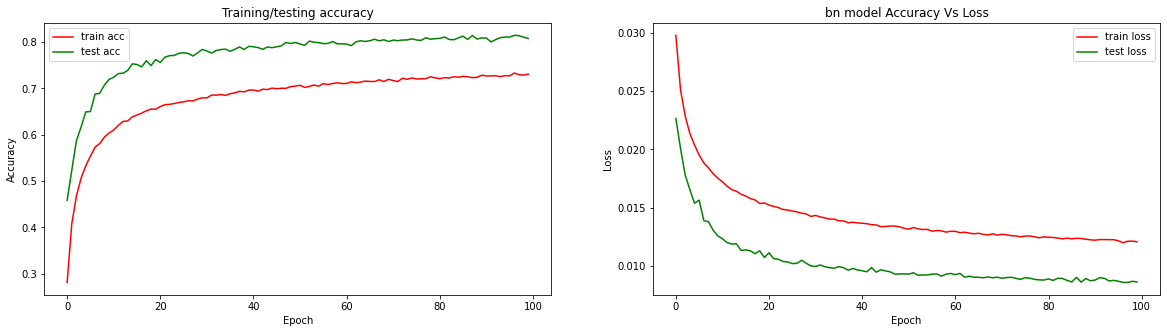

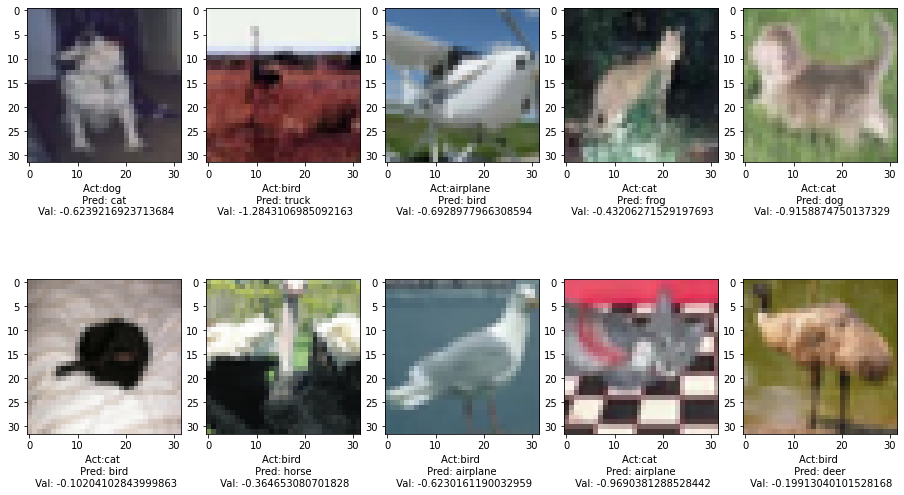

In [17]:
if __name__ == "__main__":
    batch_size = 64
    epochs = 100

    _=torch.manual_seed(1)
    if torch.cuda.is_available():
        _=torch.cuda.manual_seed(1)

    train,test = get_data()
    #take input as normal_type ['gbn','bn','gn','ln']
    # To Un Normalize the test data
    mean,std  = get_data_stats(test,train,img_norm_typ ='train',plot = False)
    
    # # Advanced Normalization
    train_transform =A.Compose([A.Resize(32,32),
                                A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                                A.ShiftScaleRotate(shift_limit=0.05,scale_limit =0.1,rotate_limit=7 ,always_apply=False),
                                A.CoarseDropout(always_apply = False,max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=mean, mask_fill_value = None),
                                A.ToGray(),
                                ToTensorV2(transpose_mask =False),
                                 ])      
    test_transform = A.Compose([A.Resize(32,32),
                                 A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                               ToTensorV2(transpose_mask =False), ])
    # #basic Normalization
    # train_transform =A.Compose([A.Resize(32,32),
    #                             A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
    #                             ToTensorV2(transpose_mask =False),
    #                             ])      
    # test_transform = A.Compose([A.Resize(32,32),
    #                             A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
    #                             ToTensorV2(transpose_mask =False,),
    #                             ])

    train_alb = AlbumDataset(train,train_transform)
    test_alb = AlbumDataset(test,test_transform)

    args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}
    train_loader = DataLoader(train_alb,batch_size=batch_size,shuffle = True,**args)
    test_loader = DataLoader(test_alb,batch_size=batch_size,**args)
    # ['gbn','bn','gn','ln']
    try_type = ['bn']
    for norm_type in try_type:

        model_class =Cifar10Net1(dropout_val = 0.05,norm_type = norm_type)
        
        # model_class = model
        model,train_losses, train_accuracy,test_losses,test_accuracy = Run_Model(model_class,train_loader,test_loader,epochs =epochs)

        plot_acc_loss(norm_type ,train_accuracy,train_losses,test_accuracy,test_losses)
        clean_gpu()

        print_wrong_image(model,test_loader,mean,std,2,5)
        clean_gpu()

In [16]:
# #model Designing 

# model = Cifar10Net1(dropout_val = 0.00,norm_type = norm_type)
# model = model.to(device)

# model.train()

# train_loader 
# for index_id,(data,target) in enumerate(train_loader):
#     data,target = data.to(device),target.to(device)
#     # optimizer.zero_grad()
#     output = model(data)
#     break
# output.shape